In [74]:
import pandas as pd
import json
f1 = open('trajectories/player_1/HA/g1.json')
f2 = open('trajectories/player_2/HA/g1.json')
f3 = open('trajectories/player_3/HA/g1.json')
f4 = open('trajectories/player_4/HA/g1.json')
f5 = open('trajectories/player_5/HA/g1.json')
data1 = json.load(f1)
data2 = json.load(f2)
data3 = json.load(f3)
data4 = json.load(f4)
data5 = json.load(f5)

In [75]:
df_ep_obs_p1 = pd.json_normalize(data1['ep_observations'][0])
df_ep_obs_p2 = pd.json_normalize(data2['ep_observations'][0])
df_ep_obs_p3 = pd.json_normalize(data3['ep_observations'][0])
df_ep_obs_p4 = pd.json_normalize(data4['ep_observations'][0])
df_ep_obs_p5 = pd.json_normalize(data5['ep_observations'][0])


In [76]:
len(df_ep_obs_p5)

804

In [77]:
def clean(df_ep_obs, data):
    df_ep_obs['agent_pos'] = df_ep_obs["players"].apply(lambda x: x[0]["position"])
    df_ep_obs['agent_ori'] = df_ep_obs["players"].apply(lambda x: x[0]["orientation"])
    df_ep_obs['agent_heldobj_name'] = df_ep_obs["players"].apply(lambda x: x[0]["held_object"]["name"] if 'held_object' in x[0].keys() else None)
    df_ep_obs['agent_heldobj_pos'] = df_ep_obs["players"].apply(lambda x: x[0]["held_object"]["position"] if 'held_object' in x[0].keys() else None)
    df_ep_obs['human_pos'] = df_ep_obs["players"].apply(lambda x: x[1]["position"])
    df_ep_obs['human_ori'] = df_ep_obs["players"].apply(lambda x: x[1]["orientation"])
    df_ep_obs['human_heldobj_name'] = df_ep_obs["players"].apply(lambda x: x[1]["held_object"]["name"] if 'held_object' in x[1].keys() else None)
    df_ep_obs['human_heldobj_pos'] = df_ep_obs["players"].apply(lambda x: x[1]["held_object"]["position"] if 'held_object' in x[1].keys() else None)
    df_ep_obs["score"]=data["ep_rewards"][0]
    df_ep_obs.drop(columns=['players','order_list'])
    return df_ep_obs

In [78]:
df_p1 = clean(df_ep_obs_p1, data1)
df_p2 = clean(df_ep_obs_p2, data2)
df_p3 = clean(df_ep_obs_p3, data3)
df_p4 = clean(df_ep_obs_p4, data4)
df_p5 = clean(df_ep_obs_p5, data5)

In [79]:
print("Player 1: Number of soups plated by agent: ",df_p1[(df_p1["agent_heldobj_name"]=='soup')].shape[0])
print("Player 1: Number of soups plated by human: ",df_p1[(df_p1["human_heldobj_name"]=='soup')].shape[0])
print("Player 2: Number of soups plated by agent: ",df_p2[(df_p2["agent_heldobj_name"]=='soup')].shape[0])
print("Player 2: Number of soups plated by human: ",df_p2[(df_p2["human_heldobj_name"]=='soup')].shape[0])
print("Player 3: Number of soups plated by agent: ",df_p3[(df_p3["agent_heldobj_name"]=='soup')].shape[0])
print("Player 3: Number of soups plated by human: ",df_p3[(df_p3["human_heldobj_name"]=='soup')].shape[0])
print("Player 4: Number of soups plated by agent: ",df_p4[(df_p4["agent_heldobj_name"]=='soup')].shape[0])
print("Player 4: Number of soups plated by human: ",df_p4[(df_p4["human_heldobj_name"]=='soup')].shape[0])
print("Player 5: Number of soups plated by agent: ",df_p5[(df_p5["agent_heldobj_name"]=='soup')].shape[0])
print("Player 5: Number of soups plated by human: ",df_p5[(df_p5["human_heldobj_name"]=='soup')].shape[0])


Player 1: Number of soups plated by agent:  46
Player 1: Number of soups plated by human:  12
Player 2: Number of soups plated by agent:  53
Player 2: Number of soups plated by human:  27
Player 3: Number of soups plated by agent:  189
Player 3: Number of soups plated by human:  46
Player 4: Number of soups plated by agent:  74
Player 4: Number of soups plated by human:  0
Player 5: Number of soups plated by agent:  121
Player 5: Number of soups plated by human:  38


In [80]:
def diff(a, b):
    if isinstance(a, list):
        return [a[0] - b[0], a[1]-b[1]]
    return None
def create_blocking_feature(df_ep_obs):
    df_ep_obs['agent_lead_pos'] = df_ep_obs['agent_pos'].shift(-1)
    df_ep_obs['human_lead_pos'] = df_ep_obs['human_pos'].shift(-1)
    df_ep_obs['diff_agent_pos'] = df_ep_obs.apply(lambda x: diff(x['agent_lead_pos'], x['agent_pos']), axis=1)
    df_ep_obs['diff_human_pos'] = df_ep_obs.apply(lambda x: diff(x['human_lead_pos'], x['human_pos']), axis=1)
    df_ep_obs['diff_agent_human_pos'] = df_ep_obs.apply(lambda x: diff(x['agent_pos'], x['human_pos']), axis=1)
    df_ep_obs['lead_diff_agent_human_pos'] = df_ep_obs['diff_agent_human_pos'].shift(-1)
    df_ep_obs['agent_human_pos'] = df_ep_obs.apply(lambda x: diff(x['lead_diff_agent_human_pos'], x['diff_agent_human_pos']), axis=1)
    # creating blocking feature
    df_ep_obs['blocking1'] = df_ep_obs["agent_human_pos"].apply(lambda x: 1 if x==[0,0] else 0)
    df_ep_obs['blocking2'] = df_ep_obs["diff_agent_pos"].apply(lambda x: 1 if x in [[-1,0],[0,-1],[1,0],[0,1]] else 0)
    df_ep_obs["blocking"] = df_ep_obs["blocking1"] & df_ep_obs["blocking2"]
    df_ep_obs["timestep"]=pd.Series(range(0,804))
    return df_ep_obs

In [81]:
df_p1 = create_blocking_feature(df_p1)
df_p2 = create_blocking_feature(df_p2)
df_p3 = create_blocking_feature(df_p3)
df_p4 = create_blocking_feature(df_p4)
df_p5 = create_blocking_feature(df_p5)

In [82]:
import matplotlib.pyplot as plt
def plot_1(df_ep_obs):
    df_ep_obs.plot(x="timestep", y=["blocking","score"])
    plt.show()

In [83]:
def calculate_ratio(df_ep_obs):
    n1=df_ep_obs[df_ep_obs["blocking"]==1].shape[0]    
    n2=df_ep_obs[df_ep_obs["score"]==20].shape[0]
    return n1/n2

In [84]:
def calculate_score(df_ep_obs):
    score=0
    for i in df_ep_obs["score"]:
        if i==20:
            score=score+20
    return score

In [85]:
ratio_p1 = calculate_ratio(df_p1)
score_p1 = calculate_score(df_p1)
ratio_p2 = calculate_ratio(df_p2)
score_p2 = calculate_score(df_p2)
ratio_p3 = calculate_ratio(df_p3)
score_p3 = calculate_score(df_p3)
ratio_p4 = calculate_ratio(df_p4)
score_p4 = calculate_score(df_p4)
ratio_p5 = calculate_ratio(df_p5)
score_p5 = calculate_score(df_p5)

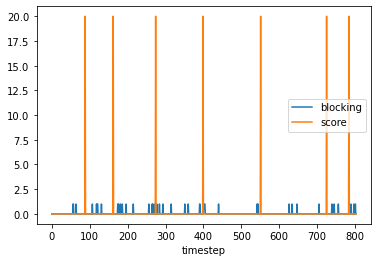

Ratio of blocks to scoring:  6.142857142857143
Score:  140


In [86]:
plot_1(df_p1)
print("Ratio of blocks to scoring: ", ratio_p1)
print("Score: ", score_p1)


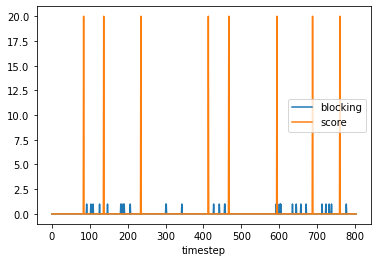

Ratio of blocks to scoring:  3.75
Score:  160


In [87]:
plot_1(df_p2)
print("Ratio of blocks to scoring: ", calculate_ratio(df_p2))
print("Score: ", calculate_score(df_p2))

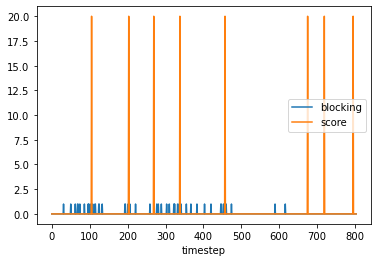

Ratio of blocks to scoring:  5.5
Score:  160


In [88]:
plot_1(df_p3)
print("Ratio of blocks to scoring: ", ratio_p3)
print("Score: ", score_p3)

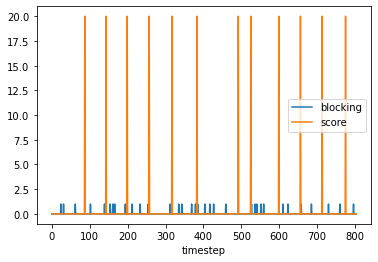

Ratio of blocks to scoring:  2.8333333333333335
Score:  240


In [89]:
plot_1(df_p4)
print("Ratio of blocks to scoring: ", ratio_p4)
print("Score: ", score_p4)

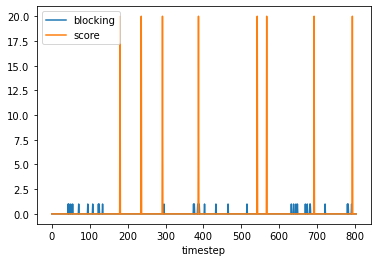

Ratio of blocks to scoring:  3.875
Score:  160


In [90]:
plot_1(df_p5)
print("Ratio of blocks to scoring: ", ratio_p5)
print("Score: ", score_p5)

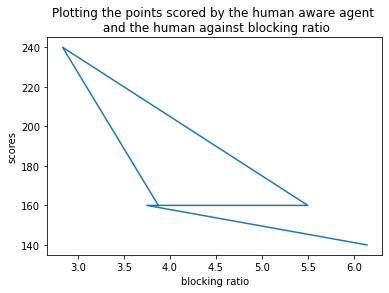

In [96]:
blocking_ratio=[ratio_p1, ratio_p2, ratio_p3, ratio_p4, ratio_p5]
scores=[score_p1, score_p2, score_p3, score_p4, score_p5]
plt.plot(blocking_ratio, scores)
plt.xlabel("blocking ratio")
plt.ylabel("scores")
plt.title("Plotting the points scored by the human aware agent \n and the human against blocking ratio")
plt.show()

In [54]:
df_p1.columns

Index(['players', 'objects', 'order_list', 'agent_pos', 'agent_ori',
       'agent_heldobj_name', 'agent_heldobj_pos', 'human_pos', 'human_ori',
       'human_heldobj_name', 'human_heldobj_pos', 'score', 'agent_lead_pos',
       'human_lead_pos', 'diff_agent_pos', 'diff_human_pos',
       'diff_agent_human_pos', 'lead_diff_agent_human_pos', 'agent_human_pos',
       'blocking1', 'blocking2', 'blocking', 'timestep'],
      dtype='object')

# SOM

In [58]:
!pip install minisom

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9021 sha256=96f1df4c37f0ff517bf04ec964c889926fc5a683a3bcd9786676b66116cc98d5
  Stored in directory: c:\users\annjo\appdata\local\pip\cache\wheels\6d\4e\9e\a95c14a232a196c22d9c04b221ff5d25461a1a4c55339c61db
Successfully built minisom


You should consider upgrading via the 'c:\users\annjo\anaconda3\python.exe -m pip install --upgrade pip' command.


In [72]:
import numpy as np
from matplotlib.patches import Patch
%matplotlib inline

from minisom import MiniSom
from sklearn.preprocessing import minmax_scale, scale
feature_names = ['score', 'blocking']

frames = [df_p1, df_p2, df_p3, df_p4, df_p5]

result = pd.concat(frames)

X = result[feature_names].values
X = scale(X)

size = 15
som = MiniSom(size, size, len(X[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.004724399321945723


C:\Users\annjo\anaconda3\lib\site-packages\minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


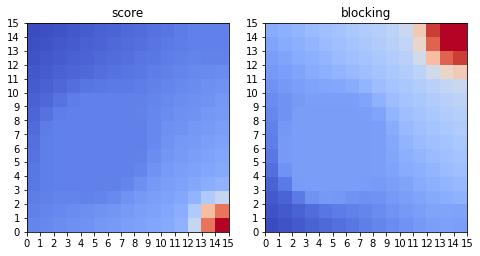

In [73]:
W = som.get_weights()
plt.figure(figsize=(10, 10))
for i, f in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()